In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import pearsonr
import warnings
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go
import plotly.express as px
warnings.filterwarnings('ignore')


In [ ]:
class SalesAnalyzer:
  def __init__(self , df):
   """Initialize the analyzer with cleaned data"""
   self.df = self.clean_data(df)
   self.segments = None
   self.segment_profiles = None

  def clean_data(self, df):
        """Clean and prepare the data"""
        # Handle missing values and data quality issues
        df = df.copy()

        # Fix negative prices (appears to be data entry error)
        df.loc[df['Price'] < 0, 'Price'] = abs(df.loc[df['Price'] < 0, 'Price'])

        # Handle missing values
        numeric_cols = ['Price', 'Competitor Price', 'Sales Volume', 'Advertising Spend (EUR)',
                       'Customer Reviews', 'Weather Index', 'Social Media Mentions',
                       'Warehouse Stock Level']

        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                df[col] = df[col].fillna(df[col].median())

        # Convert currencies to EUR for comparison (approximate rates)
        currency_rates = {'EUR': 1.0, 'TRY': 0.034}  # Approximate TRY to EUR rate
        df['Price_EUR'] = df.apply(lambda x: x['Price'] * currency_rates.get(x['Pricing Currency'], 1), axis=1)
        df['Competitor_Price_EUR'] = df.apply(lambda x: x['Competitor Price'] * currency_rates.get(x['Pricing Currency'], 1), axis=1)

        # Create price competitiveness metric
        df['Price_Competitiveness'] = (df['Competitor_Price_EUR'] - df['Price_EUR']) / df['Competitor_Price_EUR']

        # Create time periods (assuming data is sequential)
        df['Time_Period'] = range(len(df))
        df['Week_Group'] = df['Time_Period'] // 10  # Group every 10 records as a week

        return df

  def create_customer_segments(self):
        """Create customer segments based on purchase behavior patterns"""
        print("Creating customer segments based on purchase behavior...")

        # Aggregate data by product to understand purchase patterns
        product_agg = self.df.groupby(['Product ID', 'Category', 'Product Name']).agg({
            'Sales Volume': ['mean', 'std', 'sum'],
            'Price_EUR': 'mean',
            'Customer Reviews': 'mean',
            'Social Media Mentions': 'mean',
            'Advertising Spend (EUR)': 'mean'
        }).round(2)

        # Flatten column names
        product_agg.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in product_agg.columns]
        product_agg = product_agg.reset_index()

        # Create features for segmentation
        features = ['Sales Volume_mean', 'Sales Volume_std', 'Price_EUR_mean',
                   'Customer Reviews_mean', 'Social Media Mentions_mean']

        # Fill NaN values
        for feature in features:
            product_agg[feature] = product_agg[feature].fillna(product_agg[feature].median())

        # Standardize features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(product_agg[features])

        # Perform clustering
        kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
        product_agg['Segment'] = kmeans.fit_predict(features_scaled)

        # Create segment labels based on characteristics
        segment_profiles = product_agg.groupby('Segment').agg({
            'Sales Volume_mean': 'mean',
            'Price_EUR_mean': 'mean',
            'Customer Reviews_mean': 'mean',
            'Social Media Mentions_mean': 'mean'
        }).round(2)

        # Assign meaningful names to segments
        segment_names = {}
        for seg in segment_profiles.index:
            profile = segment_profiles.loc[seg]
            if profile['Sales Volume_mean'] > segment_profiles['Sales Volume_mean'].median():
                if profile['Price_EUR_mean'] > segment_profiles['Price_EUR_mean'].median():
                    segment_names[seg] = 'Premium High-Volume'
                else:
                    segment_names[seg] = 'Value High-Volume'
            else:
                if profile['Price_EUR_mean'] > segment_profiles['Price_EUR_mean'].median():
                    segment_names[seg] = 'Premium Niche'
                else:
                    segment_names[seg] = 'Budget Conscious'

        product_agg['Segment_Name'] = product_agg['Segment'].map(segment_names)

        # Merge back to main dataframe
        self.df = self.df.merge(product_agg[['Product ID', 'Segment', 'Segment_Name']],
                               on='Product ID', how='left')

        self.segments = product_agg
        self.segment_profiles = segment_profiles

        return product_agg, segment_profiles

  def segment_influence_analysis(self):
        """Analyze how different segments influence sales volume trends"""
        print("\n=== SEGMENT INFLUENCE ANALYSIS ===")

        # 1. Volume contribution by segment over time
        segment_time = self.df.groupby(['Week_Group', 'Segment_Name']).agg({
            'Sales Volume': 'sum'
        }).reset_index()

        # Calculate segment share over time
        total_by_week = segment_time.groupby('Week_Group')['Sales Volume'].sum()
        segment_time = segment_time.merge(total_by_week.rename('Total_Volume'), on='Week_Group')
        segment_time['Volume_Share'] = segment_time['Sales Volume'] / segment_time['Total_Volume'] * 100

        print("Segment Volume Share Trends:")
        pivot_share = segment_time.pivot(index='Week_Group', columns='Segment_Name', values='Volume_Share')
        print(pivot_share.round(2))

        # 2. Category influence by segment
        print("\nSegment Influence by Category:")
        category_segment = self.df.groupby(['Category', 'Segment_Name']).agg({
            'Sales Volume': ['sum', 'mean'],
            'Price_Competitiveness': 'mean'
        }).round(2)

        print(category_segment)

        # 3. Statistical significance of segment influence
        print("\nSegment Statistical Analysis:")
        for category in self.df['Category'].unique():
            cat_data = self.df[self.df['Category'] == category]
            segments = cat_data['Segment_Name'].unique()

            if len(segments) > 1:
                segment_volumes = [cat_data[cat_data['Segment_Name'] == seg]['Sales Volume'].values
                                 for seg in segments]

                # ANOVA test
                f_stat, p_value = stats.f_oneway(*segment_volumes)
                print(f"{category}: F-statistic = {f_stat:.3f}, p-value = {p_value:.3f}")

        return segment_time, category_segment



  def trend_detection(self):
        """Identify relationships driving sales trends"""
        print("\n=== TREND DETECTION ANALYSIS ===")

        # 1. Time series trends
        time_trends = self.df.groupby('Week_Group').agg({
            'Sales Volume': 'sum',
            'Price_EUR': 'mean',
            'Advertising Spend (EUR)': 'sum',
            'Customer Reviews': 'mean',
            'Social Media Mentions': 'sum',
            'Weather Index': 'mean'
        }).reset_index()

        # Calculate correlations with sales volume
        correlations = {}
        factors = ['Price_EUR', 'Advertising Spend (EUR)', 'Customer Reviews',
                  'Social Media Mentions', 'Weather Index']

        for factor in factors:
            corr, p_value = pearsonr(time_trends['Sales Volume'], time_trends[factor])
            correlations[factor] = {'correlation': corr, 'p_value': p_value}

        print("Correlation with Sales Volume:")
        # Rename the variable 'stats' to avoid conflict with the imported module
        for factor, correlation_stats in correlations.items():
            significance = "***" if correlation_stats['p_value'] < 0.001 else "**" if correlation_stats['p_value'] < 0.01 else "*" if correlation_stats['p_value'] < 0.05 else ""
            print(f"{factor}: {correlation_stats['correlation']:.3f} {significance}")

        # 2. Category-specific trend analysis
        print("\nCategory-Specific Trends:")
        for category in self.df['Category'].unique():
            cat_data = self.df[self.df['Category'] == category]
            cat_time = cat_data.groupby('Week_Group')['Sales Volume'].sum()

            # Linear trend
            x = np.array(range(len(cat_time)))
            y = cat_time.values
            # Ensure scipy.stats.linregress is called correctly
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

            trend_direction = "Increasing" if slope > 0 else "Decreasing"
            print(f"{category}: {trend_direction} trend (slope: {slope:.2f}, R²: {r_value**2:.3f})")

        return correlations, time_trends

  def competitor_impact_assessment(self):
        """Measure how competitor pricing influences sales volume"""
        print("\n=== COMPETITOR IMPACT ASSESSMENT ===")

        # 1. Price competitiveness impact
        # Positive values mean we're cheaper than competitors
        competitiveness_impact = self.df.groupby('Category').apply(
            lambda x: pearsonr(x['Price_Competitiveness'], x['Sales Volume'])
        )

        print("Price Competitiveness Impact on Sales Volume:")
        for category, (corr, p_value) in competitiveness_impact.items():
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            print(f"{category}: {corr:.3f} {significance}")

        # 2. Regression analysis for competitor impact
        print("\nRegression Analysis - Competitor Price Impact:")

        results = {}
        for category in self.df['Category'].unique():
            cat_data = self.df[self.df['Category'] == category].copy()

            # Prepare features
            X = cat_data[['Price_Competitiveness', 'Advertising Spend (EUR)',
                         'Customer Reviews', 'Social Media Mentions']].fillna(0)
            y = cat_data['Sales Volume']

            # Fit regression
            reg = LinearRegression()
            reg.fit(X, y)
            r2 = reg.score(X, y)

            results[category] = {
                'r2': r2,
                'price_coef': reg.coef_[0],
                'advertising_coef': reg.coef_[1],
                'reviews_coef': reg.coef_[2],
                'social_coef': reg.coef_[3]
            }

            print(f"\n{category}:")
            print(f"  R-squared: {r2:.3f}")
            print(f"  Price Competitiveness Coefficient: {reg.coef_[0]:.2f}")
            print(f"  (1% price advantage → {reg.coef_[0]:.1f} units volume change)")

        return results

  def additional_insights(self):
        """Generate additional important insights"""
        print("\n=== ADDITIONAL INSIGHTS ===")

        # 1. Product performance ranking
        print("Top Performing Products by Category:")
        top_products = self.df.groupby(['Category', 'Product Name']).agg({
            'Sales Volume': 'sum',
            'Price_EUR': 'mean',
            'Customer Reviews': 'mean'
        }).round(2)

        for category in self.df['Category'].unique():
            cat_products = top_products.loc[category].sort_values('Sales Volume', ascending=False)
            print(f"\n{category}:")
            print(cat_products.head(3))

        # 2. Market share analysis
        print("\nMarket Share Insights:")
        market_share = self.df.groupby(['Category', 'Market Share Rank']).agg({
            'Sales Volume': 'mean'
        }).reset_index()

        for category in self.df['Category'].unique():
            cat_share = market_share[market_share['Category'] == category]
            rank_corr = pearsonr(cat_share['Market Share Rank'], cat_share['Sales Volume'])
            print(f"{category}: Rank-Volume correlation = {rank_corr[0]:.3f}")

        # 3. Advertising efficiency
        print("\nAdvertising Efficiency by Segment:")
        ad_efficiency = self.df.groupby('Segment_Name').apply(
            lambda x: x['Sales Volume'].sum() / x['Advertising Spend (EUR)'].sum()
        ).round(3)

        for segment, efficiency in ad_efficiency.items():
            print(f"{segment}: {efficiency} units per EUR spent")

        return top_products, ad_efficiency

  def create_visualizations(self):
        """Create comprehensive visualizations"""
        plt.style.use('default')
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Sales Analysis Dashboard', fontsize=16, fontweight='bold')

        # 1. Segment volume trends
        segment_time = self.df.groupby(['Week_Group', 'Segment_Name'])['Sales Volume'].sum().reset_index()
        pivot_data = segment_time.pivot(index='Week_Group', columns='Segment_Name', values='Sales Volume')

        for col in pivot_data.columns:
            axes[0,0].plot(pivot_data.index, pivot_data[col], marker='o', label=col)
        axes[0,0].set_title('Sales Volume Trends by Segment')
        axes[0,0].set_xlabel('Week Group')
        axes[0,0].set_ylabel('Sales Volume')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # 2. Category performance
        category_perf = self.df.groupby('Category')['Sales Volume'].sum()
        axes[0,1].bar(category_perf.index, category_perf.values, color=['skyblue', 'lightcoral', 'lightgreen'])
        axes[0,1].set_title('Total Sales Volume by Category')
        axes[0,1].set_ylabel('Sales Volume')

        # 3. Price competitiveness vs sales
        axes[0,2].scatter(self.df['Price_Competitiveness'], self.df['Sales Volume'],
                         c=self.df['Category'].astype('category').cat.codes, alpha=0.6)
        axes[0,2].set_title('Price Competitiveness vs Sales Volume')
        axes[0,2].set_xlabel('Price Competitiveness')
        axes[0,2].set_ylabel('Sales Volume')
        axes[0,2].grid(True, alpha=0.3)

        # 4. Segment distribution
        segment_counts = self.df['Segment_Name'].value_counts()
        axes[1,0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%')
        axes[1,0].set_title('Product Distribution by Segment')

        # 5. Advertising spend vs sales
        axes[1,1].scatter(self.df['Advertising Spend (EUR)'], self.df['Sales Volume'],
                         c=self.df['Category'].astype('category').cat.codes, alpha=0.6)
        axes[1,1].set_title('Advertising Spend vs Sales Volume')
        axes[1,1].set_xlabel('Advertising Spend (EUR)')
        axes[1,1].set_ylabel('Sales Volume')
        axes[1,1].grid(True, alpha=0.3)

        # 6. Customer reviews impact
        review_bins = pd.cut(self.df['Customer Reviews'], bins=5)
        review_impact = self.df.groupby(review_bins)['Sales Volume'].mean()
        axes[1,2].bar(range(len(review_impact)), review_impact.values, color='gold')
        axes[1,2].set_title('Average Sales by Review Score')
        axes[1,2].set_xlabel('Review Score Range')
        axes[1,2].set_ylabel('Average Sales Volume')
        axes[1,2].set_xticks(range(len(review_impact)))
        axes[1,2].set_xticklabels([f'{interval.left:.1f}-{interval.right:.1f}'
                                  for interval in review_impact.index], rotation=45)

        plt.tight_layout()
        plt.show()

  def run_complete_analysis(self):
        """Run the complete analysis pipeline"""
        print("Starting Comprehensive Sales Analysis...")
        print("=" * 50)

        # Create segments
        segments, profiles = self.create_customer_segments()

        # Run all analyses
        segment_analysis = self.segment_influence_analysis()
        trend_analysis = self.trend_detection()
        competitor_analysis = self.competitor_impact_assessment()
        additional = self.additional_insights()

        # Create visualizations
        self.create_visualizations()

        print("\n" + "=" * 50)
        print("Analysis Complete!")

        return {
            'segments': segments,
            'segment_profiles': profiles,
            'segment_analysis': segment_analysis,
            'trend_analysis': trend_analysis,
            'competitor_analysis': competitor_analysis,
            'additional_insights': additional
        }



In [ ]:
df = pd.read_excel("/content/Sample B2C Dataset EDA.xlsx")

Running complete sales analysis...
Starting Comprehensive Sales Analysis...
Creating customer segments based on purchase behavior...

=== SEGMENT INFLUENCE ANALYSIS ===
Segment Volume Share Trends:
Segment_Name  Premium Niche  Value High-Volume
Week_Group                                    
0                     20.66              79.34
1                     28.82              71.18
2                     31.87              68.13
3                     25.51              74.49
4                     19.37              80.63
...                     ...                ...
99                    22.71              77.29
100                   43.17              56.83
101                   35.89              64.11
102                   52.41              47.59
103                   29.34              70.66

[104 rows x 2 columns]

Segment Influence by Category:
                              Sales Volume         Price_Competitiveness
                                       sum    mean            

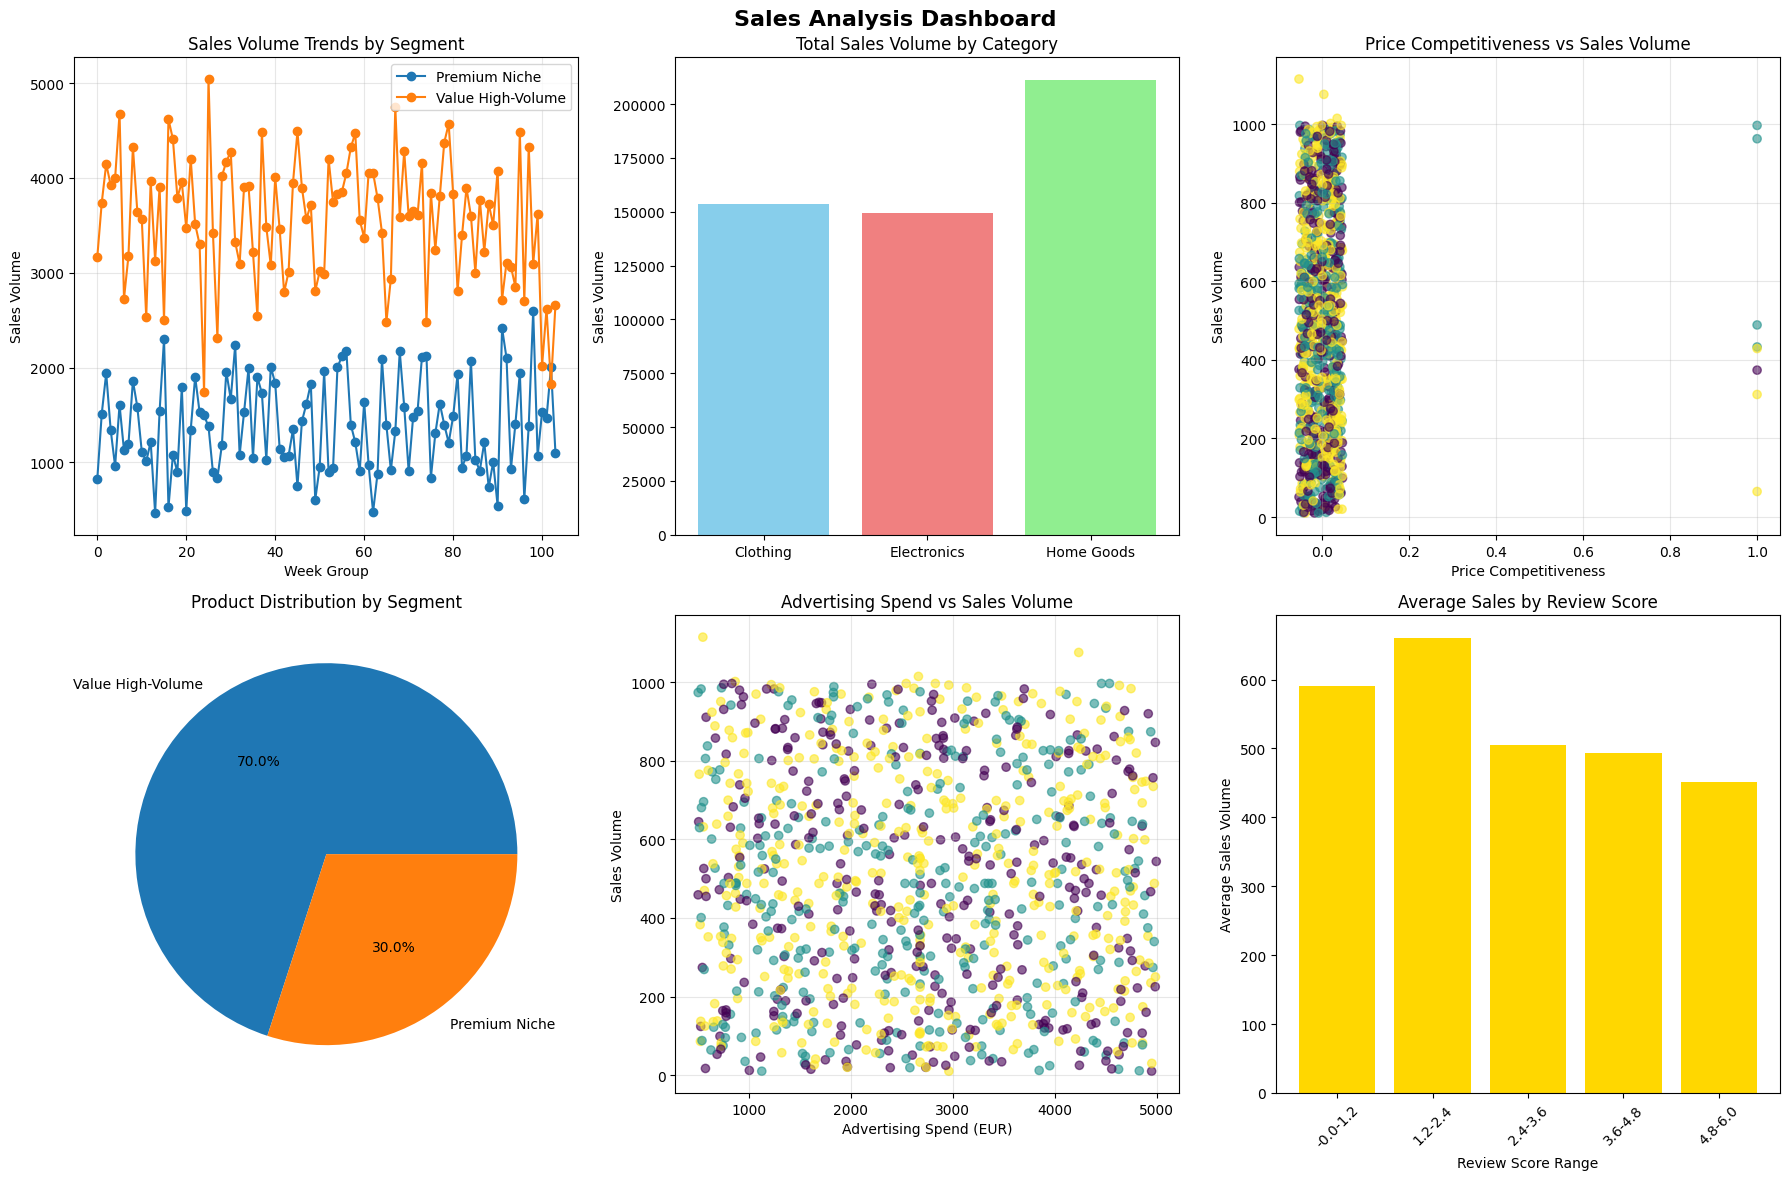


Analysis Complete!

SUMMARY OF KEY FINDINGS:

Number of customer segments identified: 4

Segment profiles:
         Sales Volume_mean  Price_EUR_mean  Customer Reviews_mean  \
Segment                                                             
0                   488.54          152.00                   4.02   
1                   534.87           81.45                   3.94   
2                   481.28          394.30                   3.88   
3                   420.81          402.32                   4.04   

         Social Media Mentions_mean  
Segment                              
0                             92.71  
1                             97.95  
2                             92.12  
3                            112.11  


In [ ]:
# Initialize the analyzer with your data
analyzer = SalesAnalyzer(df)

# Run the complete analysis
print("Running complete sales analysis...")
results = analyzer.run_complete_analysis()

# Optional: Access specific results
print("\n" + "="*50)
print("SUMMARY OF KEY FINDINGS:")
print("="*50)

# Display segment information
if analyzer.segments is not None:
    print(f"\nNumber of customer segments identified: {len(analyzer.segment_profiles)}")
    print("\nSegment profiles:")
    print(analyzer.segment_profiles)